In [1]:
import torch
from utils import create_dataframe, split_dataset
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from models import UNetV2

# Creating dataset

In [2]:
DATA_DIR = 'data/lgg-mri-segmentation/kaggle_3m'
MODEL_PATH = 'weights/best_model.pt'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

df = create_dataframe(DATA_DIR)
train_df, val_df, test_df = split_dataset(df, DATA_DIR)

# Inference

## Using trained model after 50 epochs

In [4]:
# Loading best model
print('Using previous best model...')
model = UNetV2(in_channels=3, out_channels=1).to(DEVICE)

# Load the saved state dictionary
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
# Setting to eval model to not calculate gradients
model.load_state_dict(checkpoint)

model.eval()

Using previous best model...


UNetV2(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

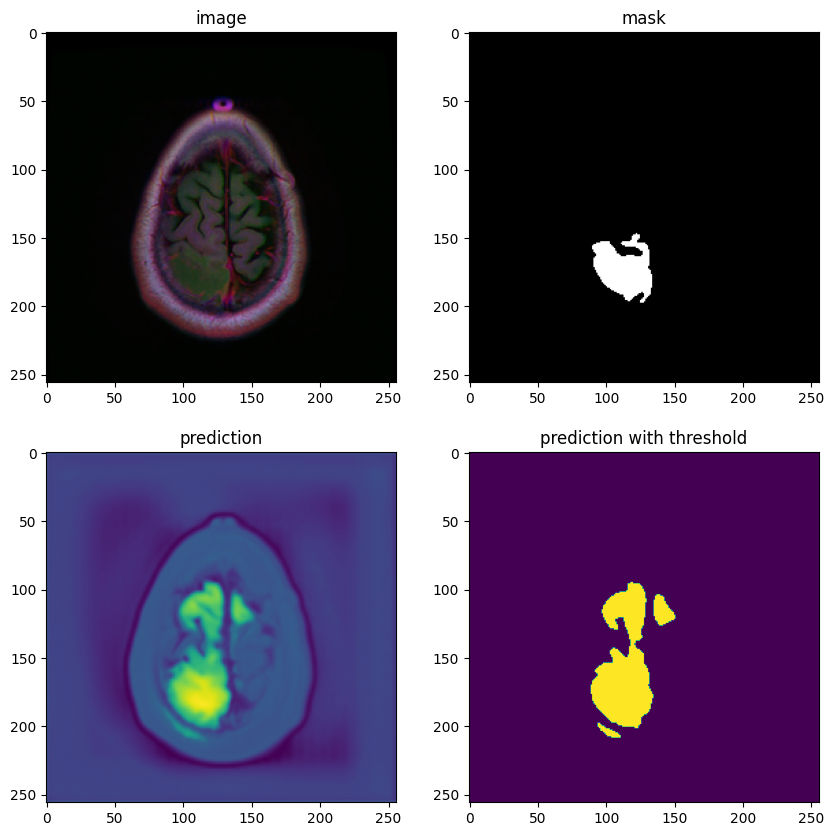

In [9]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (256, 256))
m, s = np.mean(image, axis=(0, 1)), np.std(image, axis=(0, 1))

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0921, 0.0834, 0.0877), std=(0.1356, 0.1237, 0.1292)),
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

#mask
mask = cv2.resize(cv2.imread(test_sample[1]), (256, 256))

# pred
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

with torch.no_grad():
  pred = model(input_batch)

pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with threshold
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.4)] = 0.0
pred_t[np.nonzero(pred_t >= 0.4)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

# Using pretrained UNet model

In [6]:
# Download an example image
import urllib
url, filename = ("https://github.com/mateuszbuda/brain-segmentation-pytorch/raw/master/assets/TCGA_CS_4944.png", "TCGA_CS_4944.png")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

Using cache found in C:\Users\Rodrigo/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


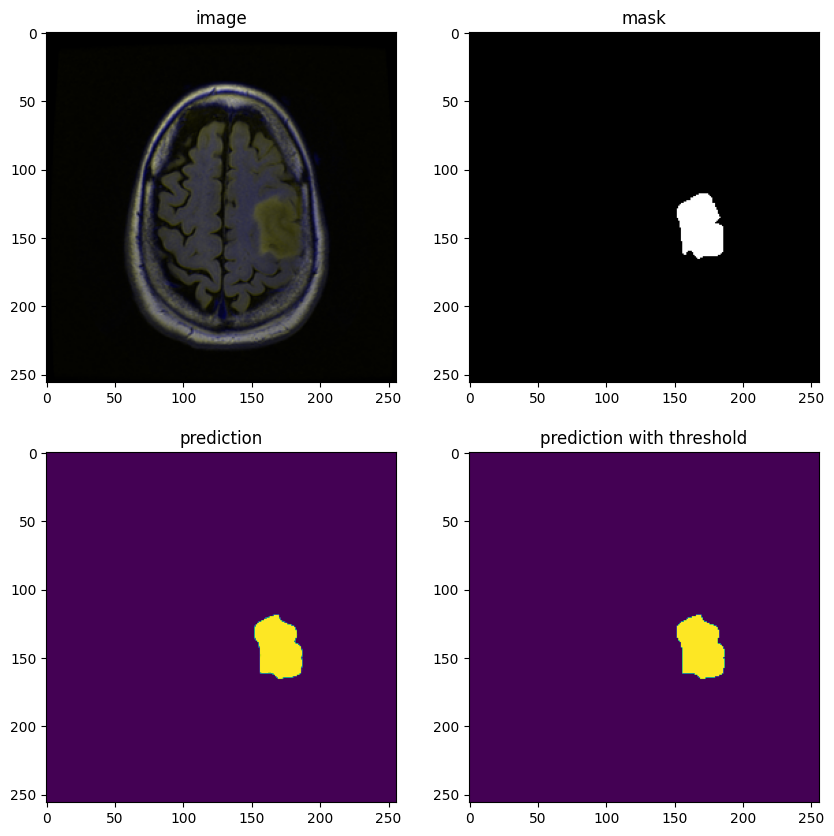

In [7]:
# Loading pretrained model from Torch Hub
pretrained_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

# Setting to eval model to not calculate gradients
pretrained_model.eval()

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    pretrained_model = pretrained_model.to('cuda')

with torch.no_grad():
    pred = pretrained_model(input_batch)
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.4)] = 0.0
pred_t[np.nonzero(pred_t >= 0.4)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()